## Notebook for analyzing tracer fluxes and mixing in temperature-salinity coordinates.

In [1]:
import numpy as np
from xgcm import Grid
import xarray as xr
import xroms
import glob
import functions #the .py file that contains all the relevant functions
from datetime import datetime

import warnings
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")

### Open histograms 

In [2]:
tefts = xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/tef_hourly_ts2d_2010.nc') #Tracer fluxes 
chits = xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/chi_hourly_2010_ts.nc') #Volume integrated salinity variance dissipation
chidv = xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/chi_unitvolume_hourly_2010.nc') #Mixing per unit volume - volume integrated

### Compute density contours in TS space using a linear equation of state

In [3]:
tempbins = np.linspace(0,40,501)
saltbins = np.linspace(0,40,501)


T,S = np.meshgrid(tempbins, saltbins)
rho = 1027.0*((1+7.6*10**(-4)*(S-35))-(1.7*10**(-4)*(T-25)))-1000 #The minus 1k is to get potential density

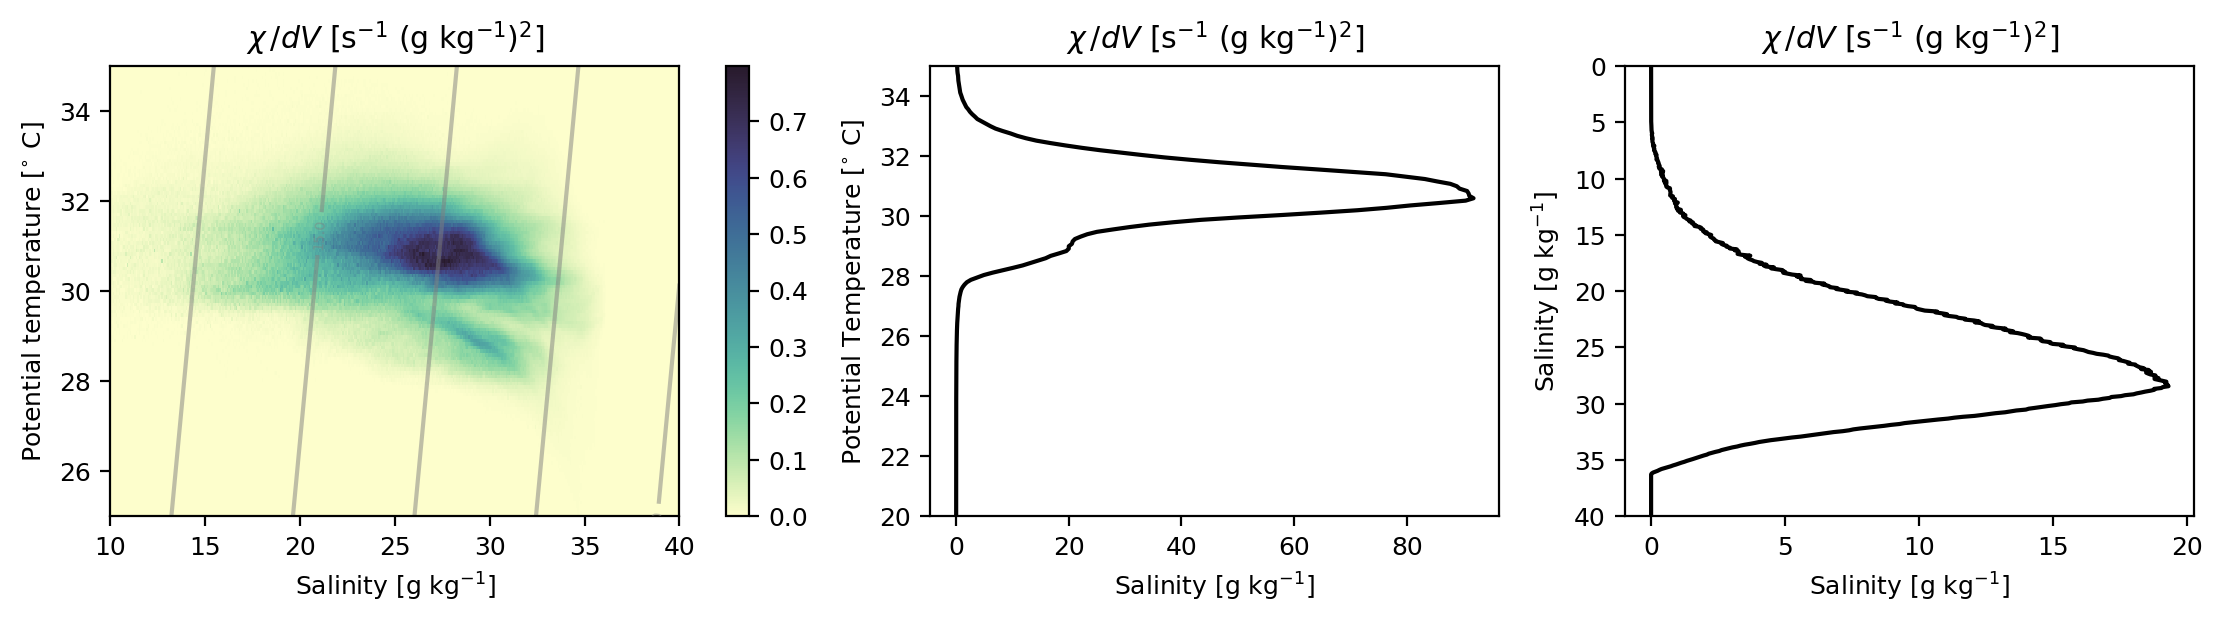

In [4]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(1,3, figsize = (11,3), dpi = 200, constrained_layout = True)

chidv.chi.sum('ocean_time').plot(ax = ax[0],
                                 y = 'temp_bin', 
                                 cmap = cmo.deep, 
                                 vmin = 0,
                                 cbar_kwargs = {'label': '','pad': 0.020,
                                               'aspect': 70})

ax[0].set_xlim(10,40)
ax[0].set_ylim(25,35)
ax[0].set_xlabel('Salinity [g kg$^{-1}$]')
ax[0].set_ylabel('Potential temperature [$^{\circ}$ C]')
ax[0].set_title('$\chi \, /dV$ [s$^{-1}$ (g kg$^{-1}$)$^2$]')

cs = ax[0].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=5,inline=True,fmt='%.1f')

chidv.chi.sum(['ocean_time', 'salt_bin']).plot(ax = ax[1],
                                               y = 'temp_bin', 
                                               color = 'k')

ax[1].set_ylim(20,35)
ax[1].set_ylabel('Potential Temperature [$^{\circ}$ C]')
ax[1].set_xlabel('Salinity [g kg$^{-1}$]')
ax[1].set_title('$\chi \, /dV $ [s$^{-1}$ (g kg$^{-1}$)$^2$]')

chidv.chi.sum(['ocean_time', 'temp_bin']).plot(ax = ax[2],
                                               y = 'salt_bin', 
                                               color = 'k')

ax[2].set_ylim(0,40)
ax[2].set_ylabel('Salinity [g kg$^{-1}$]')
ax[2].set_xlabel('Salinity [g kg$^{-1}$]')
ax[2].set_title('$\chi \, /dV$ [s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].invert_yaxis()

### Normalize the volume flux, salt flux, and salt variance flux by their maximum value & plot in TS space

In [5]:
Qnorm = tefts.Qnet.sum('ocean_time')/(tefts.Qnet.sum('ocean_time').max())
Qsnorm = tefts.Qsnet.sum('ocean_time')/(tefts.Qsnet.sum('ocean_time').max())
Qsvarnorm = tefts.Qsvarnet.sum('ocean_time')/(tefts.Qsvarnet.sum('ocean_time').max())

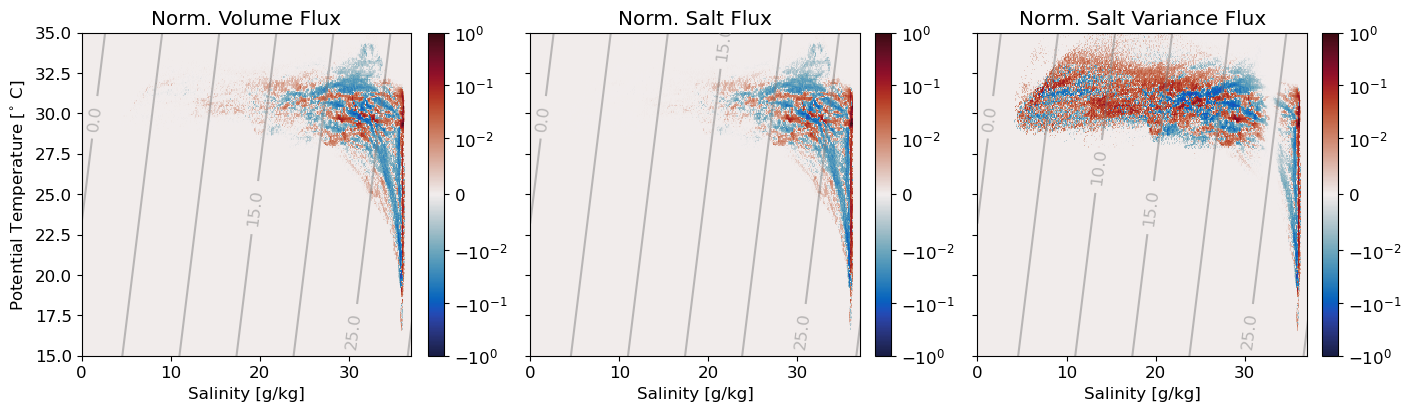

In [6]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,3, figsize = (14,4), dpi = 100, constrained_layout = True)

m0 = Qnorm.plot(y = 'temp_bin', 
           ax = ax[0],
           cmap = cmo.balance,
           norm=colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
           add_colorbar=False,)

ax[0].set_ylabel('Potential Temperature [$^{\circ}$ C]')
ax[0].set_title('Norm. Volume Flux')

m1 = Qsnorm.plot(y = 'temp_bin', 
            ax = ax[1],
            cmap = cmo.balance,
            norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
            add_colorbar=False)

ax[1].set_ylabel('')
ax[1].set_title('Norm. Salt Flux')
ax[1].axes.yaxis.set_ticklabels([])

m2 = Qsvarnorm.plot(y = 'temp_bin', 
               ax = ax[2],
               cmap = cmo.balance,
               norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
               add_colorbar=False)

ax[2].set_title('Norm. Salt Variance Flux')
ax[2].set_ylabel('')
ax[2].axes.yaxis.set_ticklabels([])

tick_locations = [-1, -0.01, -0.1, 0, 0.01, 0.1, 1]

for i in range(3):
    ax[i].set_xlim(0,37)
    ax[i].set_ylim(15,35)
    ax[i].set_xlabel('Salinity [g/kg]')
    #Plot density contours
    cs = ax[i].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    plt.colorbar(m0, ax = ax[i], aspect = 70, ticks=tick_locations, format=ticker.LogFormatterMathtext())

In [ ]:
Qnorm0 = tefts.Qnet.sel(ocean_time = '2010-06').sum('ocean_time')/(tefts.Qnet.sum('ocean_time').max())
Qsnorm0 = tefts.Qsnet.sel(ocean_time = '2010-06').sum('ocean_time')/(tefts.Qsnet.sum('ocean_time').max())
Qsvarnorm0 = tefts.Qsvarnet.sel(ocean_time = '2010-06').sum('ocean_time')/(tefts.Qsvarnet.sum('ocean_time').max())
Qnorm1 = tefts.Qnet.sel(ocean_time = '2010-07').sum('ocean_time')/(tefts.Qnet.sum('ocean_time').max())
Qsnorm1 = tefts.Qsnet.sel(ocean_time = '2010-07').sum('ocean_time')/(tefts.Qsnet.sum('ocean_time').max())
Qsvarnorm1 = tefts.Qsvarnet.sel(ocean_time = '2010-07').sum('ocean_time')/(tefts.Qsvarnet.sum('ocean_time').max())
Qnorm2 = tefts.Qnet.sel(ocean_time = '2010-08').sum('ocean_time')/(tefts.Qnet.sum('ocean_time').max())
Qsnorm2 = tefts.Qsnet.sel(ocean_time = '2010-08').sum('ocean_time')/(tefts.Qsnet.sum('ocean_time').max())
Qsvarnorm2= tefts.Qsvarnet.sel(ocean_time = '2010-08').sum('ocean_time')/(tefts.Qsvarnet.sum('ocean_time').max())

Qnorm = [Qnorm0, Qnorm1, Qnorm2]
Qsnorm = [Qsnorm0, Qsnorm1, Qsnorm2]
Qsvarnorm = [Qsvarnorm0, Qsvarnorm1, Qsvarnorm2]

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(3,3, figsize = (11,7), dpi = 100, constrained_layout = True)

for item in range(3):
    m0 = Qnorm[item].plot(y = 'temp_bin', 
               ax = ax[item,0],
               cmap = cmo.balance,
               norm=colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
               add_colorbar=False,)

    ax[item,0].set_xlim(0,37)
    ax[item,0].set_ylim(15,35)
    ax[item,0].set_ylabel('Potential Temperature [$^{\circ}$ C]')

    m1 = Qsnorm[item].plot(y = 'temp_bin', 
                ax = ax[item,1],
                cmap = cmo.balance,
                norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                add_colorbar=False)

    ax[item,1].set_xlim(0,37)
    ax[item,1].set_ylim(15,35)
    ax[item,1].set_ylabel('')
    ax[item,1].axes.yaxis.set_ticklabels([])

    m2 = Qsvarnorm[item].plot(y = 'temp_bin', 
                   ax = ax[item,2],
                   cmap = cmo.balance,
                   norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                   add_colorbar=False)

    ax[item,2].set_xlim(0,37)
    ax[item,2].set_ylim(15,35)
    ax[item,2].set_ylabel('')

    ax[item,2].axes.yaxis.set_ticklabels([])

    tick_locations = [-1, -0.01, -0.1, 0, 0.01, 0.1, 1]
    cb = plt.colorbar(m0, ax = ax[item,0], aspect = 50, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    cb = plt.colorbar(m1, ax = ax[item,1], aspect = 50, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    plt.colorbar(m2, ax = ax[item,2], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    
    cs = ax[0,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')

    cs = ax[1,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')

    cs = ax[2,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    
    ax[0,item].set_xlabel('Salinity [g/kg]')
    
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,2].axes.xaxis.set_ticklabels([])
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,2].axes.xaxis.set_ticklabels([])

ax[0,0].axes.set_xlabel('')
ax[0,1].axes.set_xlabel('')
ax[0,2].axes.set_xlabel('')
ax[1,0].axes.set_xlabel('')
ax[1,1].axes.set_xlabel('')
ax[1,2].axes.set_xlabel('')

ax[2,1].set_xlabel('Salinity [g/kg]')
ax[2,0].set_xlabel('Salinity [g/kg]')
ax[2,2].set_xlabel('Salinity [g/kg]')

ax[0,0].set_title('Norm. Volume Flux')
ax[0,1].set_title('Norm. Salt Flux')
ax[0,2].set_title('Norm. Salt Variance Flux')

In [ ]:
chinorm0 = chidv.chi.sel(ocean_time = '2010-06').sum('ocean_time')/(chidv.chi.sum('ocean_time').max())
chinorm1 = chidv.chi.sel(ocean_time = '2010-07').sum('ocean_time')/(chidv.chi.sum('ocean_time').max())
chinorm2 = chidv.chi.sel(ocean_time = '2010-08').sum('ocean_time')/(chidv.chi.sum('ocean_time').max())

chinormt0 = chidv.chi.sel(ocean_time = '2010-06').sum(['ocean_time', 'salt_bin'])/(chidv.chi.sum(['ocean_time','salt_bin']).max())
chinormt1 = chidv.chi.sel(ocean_time = '2010-07').sum(['ocean_time', 'salt_bin'])/(chidv.chi.sum(['ocean_time','salt_bin']).max())
chinormt2 = chidv.chi.sel(ocean_time = '2010-08').sum(['ocean_time', 'salt_bin'])/(chidv.chi.sum(['ocean_time','salt_bin']).max())

chinorms0 = chidv.chi.sel(ocean_time = '2010-06').sum(['ocean_time', 'temp_bin'])/(chidv.chi.sum(['ocean_time','temp_bin']).max())
chinorms1 = chidv.chi.sel(ocean_time = '2010-07').sum(['ocean_time', 'temp_bin'])/(chidv.chi.sum(['ocean_time','temp_bin']).max())
chinorms2 = chidv.chi.sel(ocean_time = '2010-08').sum(['ocean_time', 'temp_bin'])/(chidv.chi.sum(['ocean_time','temp_bin']).max())

chinorm = [chinorm0, chinorm1, chinorm2]
chinormt = [chinormt0, chinormt1, chinormt2]
chinorms = [chinorms0, chinorms1, chinorms2]

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(3,3, figsize = (11,7), dpi = 100, constrained_layout = True)

for item in range(3):
    m0 = chinorm[item].plot(y = 'temp_bin', 
                            ax = ax[item,0],
                            cmap = cmo.deep,
                            cbar_kwargs = {'label': ''}
                           )

    ax[item,0].set_xlim(10,40)
    ax[item,0].set_ylim(25,35)
    ax[item,0].set_ylabel('Potential Temperature [$^{\circ}$ C]')
    
    cs = ax[item,0].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f', manual = False)

    m1 = chinormt[item].plot(y = 'temp_bin', 
                           ax = ax[item,1], color = 'k', lw = 2)

    ax[item,1].set_ylim(25,35)
    ax[item,1].set_ylabel('')
    ax[item,1].set_ylabel('Potential Temperature [$^{\circ}$ C]')

    m2 = chinorms[item].plot(y = 'salt_bin', 
                              ax = ax[item,2], color = 'k', lw = 2)

    ax[item,2].set_ylim(0,38)
    ax[item,2].set_ylabel('Salinity [g/kg]')
   
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,2].axes.xaxis.set_ticklabels([])
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,2].axes.xaxis.set_ticklabels([])

ax[0,0].axes.set_xlabel('')
ax[0,1].axes.set_xlabel('')
ax[0,2].axes.set_xlabel('')
ax[1,0].axes.set_xlabel('')
ax[1,1].axes.set_xlabel('')
ax[1,2].axes.set_xlabel('')

ax[0,2].invert_yaxis()
ax[1,2].invert_yaxis()
ax[2,2].invert_yaxis()

ax[0,0].set_title('Norm. $\chi$')
ax[0,1].set_title('Norm. $\chi$')
ax[0,2].set_title('Norm. $\chi$')

ax[2,0].set_xlabel('Salinity [g/kg]')
ax[2,1].set_xlabel('')
ax[2,2].set_xlabel('')

### Some interesting trends emerge when we look at mixing per unit volume instead of mixing. What this tells us is that the strongest mixing is almost completely diapycnal. If we plot the integrated mixing instead - we expect it to look very similar to the tracer fluxes because of large volume aliased towards the southern and western boundaries of the control volume. 

In [ ]:
vint_ts = xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/vint_hourly_2010_ts.nc')
zrh_ts = xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/zrh_hourly_2010_ts.nc')

In [ ]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,2, figsize = (6,2.5), dpi = 200)

p1 = -zrh_ts.histogram_salt_temp.sum('ocean_time')
p2 = vint_ts.histogram_salt_temp.sum('ocean_time')

np.log10(p1).plot(ax = ax[0],
                 y = 'temp_bin', 
                 cmap = cmo.thermal, 
                 vmin = 3, vmax = 7,
                 cbar_kwargs = {'label': '',
                           'pad': 0.025})

np.log10(p2).plot(ax = ax[1],
                 y = 'temp_bin', 
                 cmap = cmo.thermal, 
                 vmin = 8, vmax = 12,
                 cbar_kwargs = {'label': '',
                           'pad': 0.025})
ax[0].set_xlabel('')
ax[0].set_title('Water parcel depth [m]')
ax[0].set_ylim(15,40)
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Potential Temperature [$^{\circ}$ C]')

ax[1].set_ylabel('')
ax[1].set_ylim(15,40)
ax[1].set_title('Box volume [m$^3$]')
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_xlabel('Salinity [g/kg]')

In [ ]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(1,3, figsize = (11,3), dpi = 200, constrained_layout = True)

np.log10(chits.chi.sum('ocean_time')).plot(ax = ax[0],
                                           y = 'temp_bin', 
                                           cmap = cmo.matter,
                                           vmin = 3,
                                           vmax = 7,
                                           cbar_kwargs = {'label': '','pad': 0.020,
                                                'aspect': 70})

ax[0].set_xlim(10,40)
ax[0].set_ylim(15,35)
ax[0].set_xlabel('Salinity [g kg$^{-1}$]')
ax[0].set_ylabel('Potential temperature [$^{\circ}$ C]')
ax[0].set_title('log($\chi$) [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')

cs = ax[0].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=5,inline=True,fmt='%.1f')

chits.chi.sum(['ocean_time', 'salt_bin']).plot(ax = ax[1],
                                               y = 'temp_bin', 
                                               color = 'k')

ax[1].set_ylim(20,35)
ax[1].set_ylabel('Potential Temperature [$^{\circ}$ C]')
ax[1].set_xlabel('Salinity [g kg$^{-1}$]')
ax[1].set_title('$\chi$ [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')

chits.chi.sum(['ocean_time', 'temp_bin']).plot(ax = ax[2],
                                               y = 'salt_bin', 
                                               color = 'k')

ax[2].set_ylim(0,40)
ax[2].set_ylabel('Salinity [g kg$^{-1}$]')
ax[2].set_xlabel('Salinity [g kg$^{-1}$]')
ax[2].set_title('$\chi$ [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].invert_yaxis()